In [3]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time


%matplotlib inline

In [4]:
data_1=pd.read_csv("/kaggle/input/bankpromotion/bank-additional-full.csv",sep=";")
data_2=pd.read_csv("/kaggle/input/bankpromotion/bank-additional.csv",sep=";")
data=pd.concat([data_1,data_2],axis=0)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
#To avoid mulicorinality drop the higly correltaed column
data = data.drop(["emp.var.rate","nr.employed"],axis=1)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,93.994,-36.4,4.857,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,93.994,-36.4,4.857,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,93.994,-36.4,4.857,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,93.994,-36.4,4.857,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,93.994,-36.4,4.857,no


In [6]:

#label encoding

jobDummies = pd.get_dummies(data['job'], prefix = 'job')
maritalDummies = pd.get_dummies(data['marital'], prefix = 'marital')
educationDummies = pd.get_dummies(data['education'], prefix = 'education')
defaultDummies = pd.get_dummies(data['default'], prefix = 'default')
housingDummies = pd.get_dummies(data['housing'], prefix = 'housing')
loanDummies = pd.get_dummies(data['loan'], prefix = 'loan')
contactDummies = pd.get_dummies(data['contact'], prefix = 'contact')
poutcomeDummies = pd.get_dummies(data['poutcome'], prefix = 'poutcome')
data['month']=data['month'].astype('category')
data['day_of_week']=data['day_of_week'].astype('category')
data['y']=data['y'].astype('category')

# Assigning numerical values and storing in another column
data['month'] = data['month'].cat.codes
data['day_of_week'] = data['day_of_week'].cat.codes
data['y'] = data['y'].cat.codes

data['y'].dtype


dtype('int8')

In [7]:
data["age"]=data["age"].astype("int")
data["duration"]=data["duration"].astype("int")
data["pdays"]=data["pdays"].astype("int")
data["previous"]=data["previous"].astype("int")
data["campaign"]=data["campaign"].astype("int")
data_int=data.select_dtypes(include=['int','float64','bool'])
#data_int
bank_df=pd.concat([data_int,jobDummies,maritalDummies,educationDummies,defaultDummies,housingDummies,loanDummies
                  ,contactDummies,poutcomeDummies,data['month'],data['day_of_week'],data['y']],axis=1)
bank_df.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,job_admin.,job_blue-collar,...,loan_unknown,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,month,day_of_week,y
0,56,261,1,999,0,93.994,-36.4,4.857,0,0,...,0,0,0,1,0,1,0,6,1,0
1,57,149,1,999,0,93.994,-36.4,4.857,0,0,...,0,0,0,1,0,1,0,6,1,0
2,37,226,1,999,0,93.994,-36.4,4.857,0,0,...,0,0,0,1,0,1,0,6,1,0
3,40,151,1,999,0,93.994,-36.4,4.857,1,0,...,0,0,0,1,0,1,0,6,1,0
4,56,307,1,999,0,93.994,-36.4,4.857,0,0,...,0,1,0,1,0,1,0,6,1,0


In [8]:
#Total features after one-hot-encoding
features = bank_df.columns
len(features)

49

In [9]:

#Variables and Output
y=np.array(bank_df["y"])
X=np.array(bank_df.iloc[:,0:48])

# PCA

[6.56847580e-01 3.41670954e-01 1.06343975e-03 2.07113969e-04
 7.51425802e-05 5.25227929e-05 2.56822419e-05 1.88938423e-05
 4.79060388e-06 4.21212634e-06 3.48435744e-06 2.98854463e-06
 2.71868187e-06 2.57998910e-06]


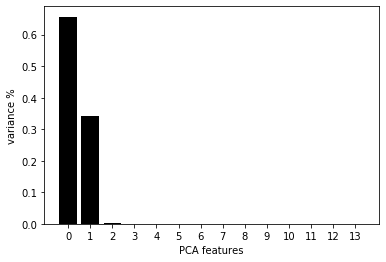

In [10]:
# Create a PCA instance: pca
pca = PCA(n_components=14)
principalComponents = pca.fit_transform(X)# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print(pca.explained_variance_ratio_)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

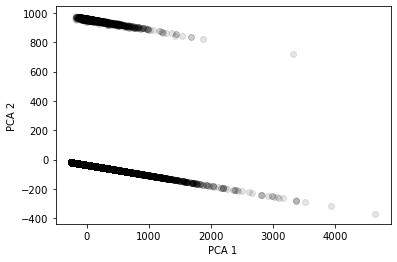

In [11]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [12]:
PCA_components.iloc[:,:3]

,0,1,2
0,0.215547,-36.782440,16.293932
1,-111.496146,-28.752251,17.292791
2,-34.698006,-34.310547,-2.668005
3,-109.504450,-28.928350,0.328278
4,46.097183,-40.079961,16.277539
...,...,...,...
45302,-207.253570,-21.938576,-10.055520
45303,-41.679321,-33.821248,-1.082093
45304,-196.281413,-22.727219,-13.350719
45305,266.528546,-55.920054,18.315961


In [13]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(PCA_components.iloc[:,:2], y, test_size=0.2, random_state=1)

In [14]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(36245, 2)


In [15]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 2 layers
model = Sequential()
model.add(Dense(100, input_dim=n_cols, activation='relu'))
model.add(Dense(50,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
epochs= 200
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Train on 28996 samples, validate on 7249 samples
Epoch 1/200
28996/28996 [==============================] - 1s 30us/step - loss: 0.4781 - accuracy: 0.8896 - val_loss: 0.3627 - val_accuracy: 0.8858
Epoch 2/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.3803 - accuracy: 0.8940 - val_loss: 0.3402 - val_accuracy: 0.8921
Epoch 3/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.3542 - accuracy: 0.8968 - val_loss: 0.3150 - val_accuracy: 0.9023
Epoch 4/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.3375 - accuracy: 0.8965 - val_loss: 0.3279 - val_accuracy: 0.8966
Epoch 5/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.3590 - accuracy: 0.8956 - val_loss: 0.3053 - val_accuracy: 0.8941
Epoch 6/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.3262 - accuracy: 0.8957 - val_loss: 0.3404 - val_accuracy: 0.8937
Epoch 7/200
28996/28996 [==============================] - 0s 1

Epoch 56/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2460 - accuracy: 0.9061 - val_loss: 0.2488 - val_accuracy: 0.9045
Epoch 57/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2456 - accuracy: 0.9057 - val_loss: 0.2483 - val_accuracy: 0.9021
Epoch 58/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2453 - accuracy: 0.9071 - val_loss: 0.2501 - val_accuracy: 0.9045
Epoch 59/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2459 - accuracy: 0.9059 - val_loss: 0.2501 - val_accuracy: 0.9051
Epoch 60/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2452 - accuracy: 0.9064 - val_loss: 0.2482 - val_accuracy: 0.9025
Epoch 61/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2457 - accuracy: 0.9047 - val_loss: 0.2489 - val_accuracy: 0.9039
Epoch 62/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2460 - accuracy: 0.9055

Epoch 111/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2446 - accuracy: 0.9080 - val_loss: 0.2478 - val_accuracy: 0.9038
Epoch 112/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2448 - accuracy: 0.9073 - val_loss: 0.2473 - val_accuracy: 0.9016
Epoch 113/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2448 - accuracy: 0.9076 - val_loss: 0.2474 - val_accuracy: 0.9066
Epoch 114/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2449 - accuracy: 0.9069 - val_loss: 0.2482 - val_accuracy: 0.9046
Epoch 115/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2450 - accuracy: 0.9071 - val_loss: 0.2480 - val_accuracy: 0.9055
Epoch 116/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2448 - accuracy: 0.9071 - val_loss: 0.2474 - val_accuracy: 0.9065
Epoch 117/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2443 - accuracy:

28996/28996 [==============================] - 0s 17us/step - loss: 0.2442 - accuracy: 0.9076 - val_loss: 0.2476 - val_accuracy: 0.9029
Epoch 166/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2445 - accuracy: 0.9081 - val_loss: 0.2484 - val_accuracy: 0.9056
Epoch 167/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2444 - accuracy: 0.9076 - val_loss: 0.2475 - val_accuracy: 0.9056
Epoch 168/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2442 - accuracy: 0.9075 - val_loss: 0.2481 - val_accuracy: 0.9018
Epoch 169/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2441 - accuracy: 0.9071 - val_loss: 0.2473 - val_accuracy: 0.9044
Epoch 170/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2445 - accuracy: 0.9080 - val_loss: 0.2498 - val_accuracy: 0.9045
Epoch 171/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2442 - accuracy: 0.9081 - val_

In [17]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

9062/9062 [==============================] - 0s 12us/step


In [18]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.904878
Precision: 0.643253
Recall: 0.342183
F1 score: 0.446727


In [19]:


# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)

ROC AUC: 0.862857


In [20]:
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

[[7852  193]
 [ 669  348]]


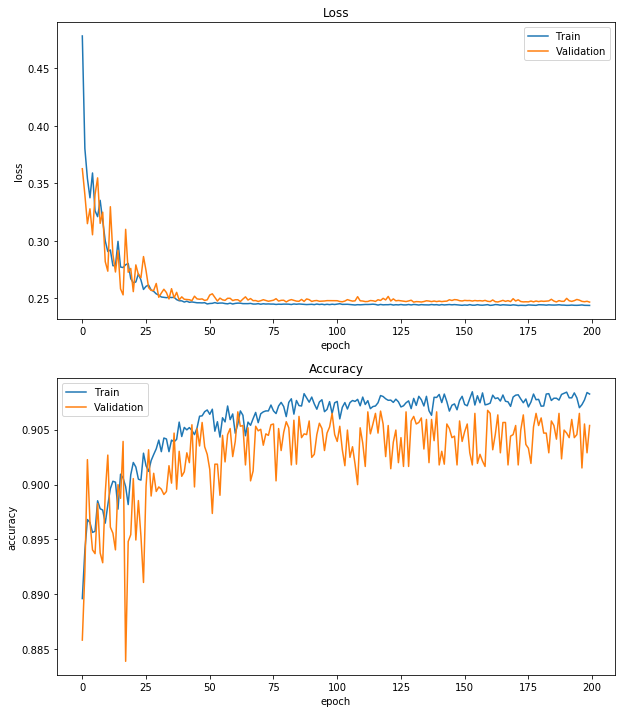

In [21]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# RCA

In [22]:
rca = GaussianRandomProjection(n_components=2, eps=0.1, random_state=42)
X_rca=rca.fit_transform(X)

In [23]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_rca, y, test_size=0.2, random_state=1)

In [24]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(36245, 2)


In [25]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 3 layers
model = Sequential()
model.add(Dense(100, input_dim=n_cols, activation='relu'))
model.add(Dense(50,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:

epochs= 200
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Train on 28996 samples, validate on 7249 samples
Epoch 1/200
28996/28996 [==============================] - 1s 23us/step - loss: 1.5951 - accuracy: 0.8781 - val_loss: 0.3954 - val_accuracy: 0.8970
Epoch 2/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.4019 - accuracy: 0.8878 - val_loss: 0.5261 - val_accuracy: 0.7574
Epoch 3/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.3820 - accuracy: 0.8897 - val_loss: 0.4228 - val_accuracy: 0.8952
Epoch 4/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.4188 - accuracy: 0.8885 - val_loss: 0.5253 - val_accuracy: 0.8028
Epoch 5/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.3918 - accuracy: 0.8895 - val_loss: 0.2904 - val_accuracy: 0.8978
Epoch 6/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.3763 - accuracy: 0.8892 - val_loss: 0.4681 - val_accuracy: 0.6868
Epoch 7/200
28996/28996 [==============================] - 0s 1

Epoch 56/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2461 - accuracy: 0.9075 - val_loss: 0.2504 - val_accuracy: 0.9047
Epoch 57/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2457 - accuracy: 0.9072 - val_loss: 0.2485 - val_accuracy: 0.9007
Epoch 58/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2460 - accuracy: 0.9075 - val_loss: 0.2487 - val_accuracy: 0.9057
Epoch 59/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2460 - accuracy: 0.9073 - val_loss: 0.2527 - val_accuracy: 0.9012
Epoch 60/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2467 - accuracy: 0.9067 - val_loss: 0.2510 - val_accuracy: 0.9047
Epoch 61/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2455 - accuracy: 0.9080 - val_loss: 0.2514 - val_accuracy: 0.9058
Epoch 62/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2467 - accuracy: 0.9073

Epoch 111/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2452 - accuracy: 0.9074 - val_loss: 0.2497 - val_accuracy: 0.9044
Epoch 112/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2458 - accuracy: 0.9075 - val_loss: 0.2480 - val_accuracy: 0.9061
Epoch 113/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2449 - accuracy: 0.9080 - val_loss: 0.2481 - val_accuracy: 0.9061
Epoch 114/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2459 - accuracy: 0.9073 - val_loss: 0.2476 - val_accuracy: 0.9049
Epoch 115/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2456 - accuracy: 0.9080 - val_loss: 0.2478 - val_accuracy: 0.9062
Epoch 116/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2453 - accuracy: 0.9070 - val_loss: 0.2480 - val_accuracy: 0.9037
Epoch 117/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2447 - accuracy:

28996/28996 [==============================] - 1s 18us/step - loss: 0.2447 - accuracy: 0.9075 - val_loss: 0.2477 - val_accuracy: 0.9059
Epoch 166/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2444 - accuracy: 0.9078 - val_loss: 0.2478 - val_accuracy: 0.9059
Epoch 167/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2447 - accuracy: 0.9077 - val_loss: 0.2480 - val_accuracy: 0.9032
Epoch 168/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2446 - accuracy: 0.9085 - val_loss: 0.2476 - val_accuracy: 0.9038
Epoch 169/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2446 - accuracy: 0.9077 - val_loss: 0.2475 - val_accuracy: 0.9048
Epoch 170/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2441 - accuracy: 0.9078 - val_loss: 0.2479 - val_accuracy: 0.9052
Epoch 171/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2448 - accuracy: 0.9073 - val_

In [27]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

9062/9062 [==============================] - 0s 13us/step


In [28]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.904878
Precision: 0.647619
Recall: 0.334317
F1 score: 0.440986


In [29]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.862559
[[7860  185]
 [ 677  340]]


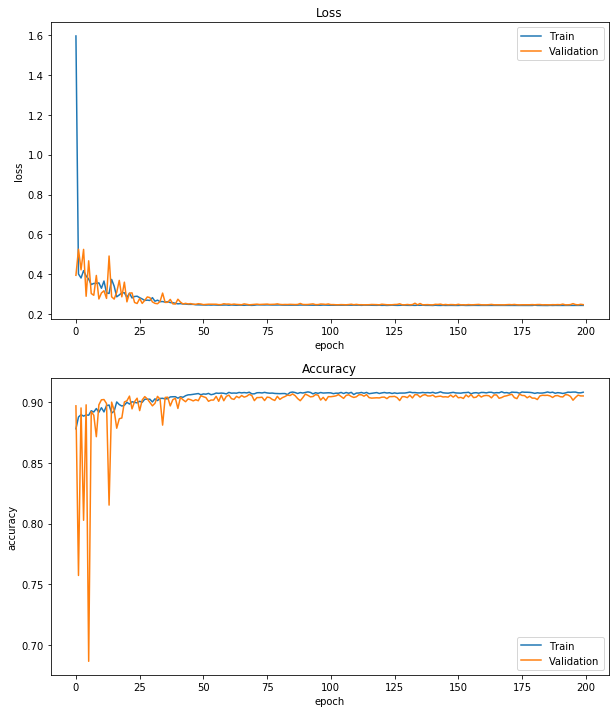

In [30]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Feature Selection - Random Forest

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [32]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [33]:
boolvec=sel.get_support()
boolvec.astype(bool)
boolvec

array([ True,  True,  True,  True, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True])

In [35]:
input_file=bank_df.iloc[:,0:48]
#X_RF=input_file.loc[:, sel.get_support()]
#input_file=sgemm_df.loc[:, sel.get_support()].head()
selected_feat= input_file.columns[(sel.get_support())]
#selected_feat = np.where(boolvec[:,None], X_train,X_train)
len(selected_feat)

10

In [36]:
print(selected_feat)
#sgemm_df

Index(['age', 'duration', 'campaign', 'pdays', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'poutcome_success', 'month',
       'day_of_week'],
      dtype='object')


In [37]:
X_RF=input_file.loc[:, sel.get_support()]

In [38]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_RF, y, test_size=0.2, random_state=1)


In [40]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(36245, 2)


In [41]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 3 layers
model = Sequential()
model.add(Dense(100, input_dim=n_cols, activation='relu'))
model.add(Dense(50,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
epochs= 200
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Train on 28996 samples, validate on 7249 samples
Epoch 1/200
28996/28996 [==============================] - 1s 23us/step - loss: 2.6185 - accuracy: 0.8761 - val_loss: 0.3684 - val_accuracy: 0.9037
Epoch 2/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.3693 - accuracy: 0.8897 - val_loss: 0.3812 - val_accuracy: 0.9023
Epoch 3/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.3349 - accuracy: 0.8935 - val_loss: 0.2526 - val_accuracy: 0.9031
Epoch 4/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2972 - accuracy: 0.8965 - val_loss: 0.2585 - val_accuracy: 0.9036
Epoch 5/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2831 - accuracy: 0.8976 - val_loss: 0.2352 - val_accuracy: 0.9044
Epoch 6/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2992 - accuracy: 0.8976 - val_loss: 0.2276 - val_accuracy: 0.9031
Epoch 7/200
28996/28996 [==============================] - 1s 1

Epoch 56/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2074 - accuracy: 0.9072 - val_loss: 0.2037 - val_accuracy: 0.9050
Epoch 57/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2100 - accuracy: 0.9058 - val_loss: 0.2149 - val_accuracy: 0.9013
Epoch 58/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2043 - accuracy: 0.9090 - val_loss: 0.2068 - val_accuracy: 0.9049
Epoch 59/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2050 - accuracy: 0.9084 - val_loss: 0.2185 - val_accuracy: 0.9001
Epoch 60/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2120 - accuracy: 0.9068 - val_loss: 0.2074 - val_accuracy: 0.9047
Epoch 61/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2050 - accuracy: 0.9081 - val_loss: 0.2176 - val_accuracy: 0.9029
Epoch 62/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2061 - accuracy: 0.9068

Epoch 111/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.1966 - accuracy: 0.9107 - val_loss: 0.2040 - val_accuracy: 0.9030
Epoch 112/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.1968 - accuracy: 0.9100 - val_loss: 0.2001 - val_accuracy: 0.9064
Epoch 113/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.1980 - accuracy: 0.9105 - val_loss: 0.1993 - val_accuracy: 0.9077
Epoch 114/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.1965 - accuracy: 0.9107 - val_loss: 0.2018 - val_accuracy: 0.9070
Epoch 115/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.1968 - accuracy: 0.9110 - val_loss: 0.2009 - val_accuracy: 0.9056
Epoch 116/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.1984 - accuracy: 0.9110 - val_loss: 0.2035 - val_accuracy: 0.9081
Epoch 117/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.1987 - accuracy:

28996/28996 [==============================] - 1s 18us/step - loss: 0.1944 - accuracy: 0.9123 - val_loss: 0.2009 - val_accuracy: 0.9054
Epoch 166/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.1956 - accuracy: 0.9117 - val_loss: 0.2098 - val_accuracy: 0.9051
Epoch 167/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.1948 - accuracy: 0.9127 - val_loss: 0.2080 - val_accuracy: 0.9059
Epoch 168/200
28996/28996 [==============================] - 1s 19us/step - loss: 0.1941 - accuracy: 0.9116 - val_loss: 0.2050 - val_accuracy: 0.9056
Epoch 169/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.1945 - accuracy: 0.9122 - val_loss: 0.2063 - val_accuracy: 0.9036
Epoch 170/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.1950 - accuracy: 0.9124 - val_loss: 0.2001 - val_accuracy: 0.9077
Epoch 171/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.1937 - accuracy: 0.9132 - val_

In [43]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

9062/9062 [==============================] - 0s 11us/step


In [44]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.909292
Precision: 0.684310
Recall: 0.355949
F1 score: 0.468305


In [45]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.926179
[[7878  167]
 [ 655  362]]


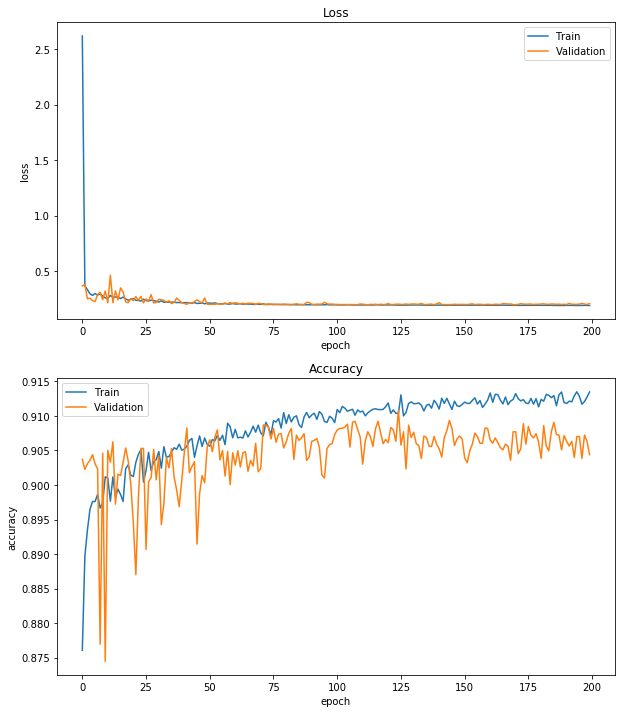

In [46]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# ICA

In [47]:
ICA = FastICA(n_components=2, random_state=42) 
X_ica=ICA.fit_transform(X)

In [48]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_ica, y, test_size=0.2, random_state=1)

In [49]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(36245, 2)


In [50]:
# define the model
#get number of columns in training data
n_cols=X_train_scaled.shape[1]

# define model 3 layers
model = Sequential()
model.add(Dense(100, input_dim=n_cols, activation='relu'))
model.add(Dense(50,  activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
epochs= 200
start=time.time()
#fit model
hist=model.fit(X_train_scaled, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Train on 28996 samples, validate on 7249 samples
Epoch 1/200
28996/28996 [==============================] - 1s 23us/step - loss: 0.3940 - accuracy: 0.8869 - val_loss: 0.3364 - val_accuracy: 0.8863
Epoch 2/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.3082 - accuracy: 0.8892 - val_loss: 0.2818 - val_accuracy: 0.8912
Epoch 3/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2654 - accuracy: 0.9011 - val_loss: 0.2608 - val_accuracy: 0.9023
Epoch 4/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2558 - accuracy: 0.9044 - val_loss: 0.2566 - val_accuracy: 0.9011
Epoch 5/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2540 - accuracy: 0.9064 - val_loss: 0.2554 - val_accuracy: 0.9029
Epoch 6/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2517 - accuracy: 0.9067 - val_loss: 0.2548 - val_accuracy: 0.9004
Epoch 7/200
28996/28996 [==============================] - 1s 1

Epoch 56/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2458 - accuracy: 0.9076 - val_loss: 0.2488 - val_accuracy: 0.9064
Epoch 57/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2470 - accuracy: 0.9074 - val_loss: 0.2492 - val_accuracy: 0.9054
Epoch 58/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2463 - accuracy: 0.9070 - val_loss: 0.2490 - val_accuracy: 0.9063
Epoch 59/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2460 - accuracy: 0.9078 - val_loss: 0.2506 - val_accuracy: 0.9024
Epoch 60/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2461 - accuracy: 0.9074 - val_loss: 0.2493 - val_accuracy: 0.9053
Epoch 61/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2457 - accuracy: 0.9074 - val_loss: 0.2521 - val_accuracy: 0.9039
Epoch 62/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2458 - accuracy: 0.9077

Epoch 111/200
28996/28996 [==============================] - 1s 19us/step - loss: 0.2451 - accuracy: 0.9082 - val_loss: 0.2480 - val_accuracy: 0.9049
Epoch 112/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2451 - accuracy: 0.9078 - val_loss: 0.2495 - val_accuracy: 0.9033
Epoch 113/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2449 - accuracy: 0.9081 - val_loss: 0.2473 - val_accuracy: 0.9056
Epoch 114/200
28996/28996 [==============================] - 0s 17us/step - loss: 0.2453 - accuracy: 0.9068 - val_loss: 0.2490 - val_accuracy: 0.9054
Epoch 115/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2442 - accuracy: 0.9085 - val_loss: 0.2483 - val_accuracy: 0.9051
Epoch 116/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2450 - accuracy: 0.9073 - val_loss: 0.2492 - val_accuracy: 0.9054
Epoch 117/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2447 - accuracy:

28996/28996 [==============================] - 1s 18us/step - loss: 0.2448 - accuracy: 0.9079 - val_loss: 0.2471 - val_accuracy: 0.9067
Epoch 166/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2446 - accuracy: 0.9078 - val_loss: 0.2475 - val_accuracy: 0.9065
Epoch 167/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2447 - accuracy: 0.9076 - val_loss: 0.2485 - val_accuracy: 0.9053
Epoch 168/200
28996/28996 [==============================] - 1s 17us/step - loss: 0.2445 - accuracy: 0.9083 - val_loss: 0.2498 - val_accuracy: 0.9020
Epoch 169/200
28996/28996 [==============================] - 1s 21us/step - loss: 0.2447 - accuracy: 0.9076 - val_loss: 0.2509 - val_accuracy: 0.9020
Epoch 170/200
28996/28996 [==============================] - 1s 19us/step - loss: 0.2448 - accuracy: 0.9075 - val_loss: 0.2468 - val_accuracy: 0.9063
Epoch 171/200
28996/28996 [==============================] - 1s 18us/step - loss: 0.2444 - accuracy: 0.9076 - val_

In [52]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_scaled, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=1)

9062/9062 [==============================] - 0s 15us/step


In [53]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)


Accuracy: 0.904657
Precision: 0.633508
Recall: 0.356932
F1 score: 0.456604


In [54]:
# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.862848
[[7835  210]
 [ 654  363]]


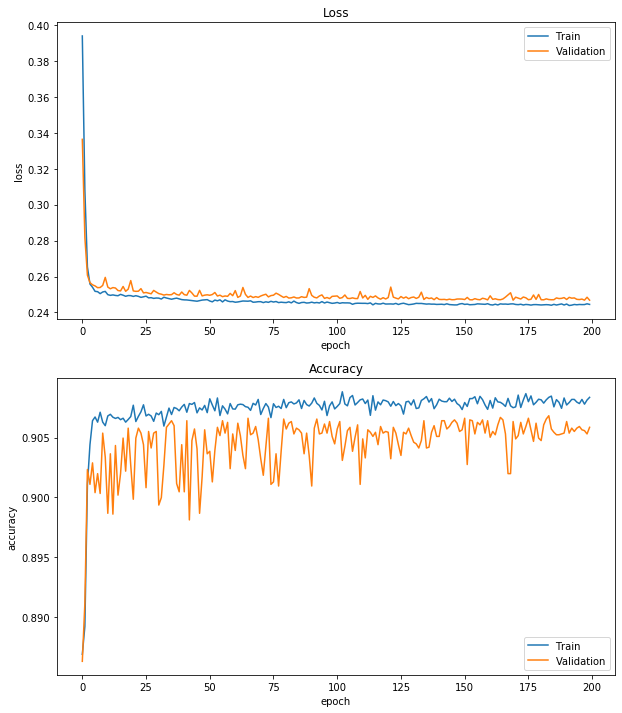

In [55]:
# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()